This first sell below are installing and testing the packages

In [11]:
import torch
print("PyTorch version:", torch.__version__)

import torchaudio
print("torchaudio version:", torchaudio.__version__)

import librosa
print("Librosa version:", librosa.__version__)

import numpy as np
print("NumPy version:", np.__version__)

import pandas as pd
print("Pandas version:", pd.__version__)

import matplotlib
print("Matplotlib version:", matplotlib.__version__)

import scipy
print("SciPy version:", scipy.__version__)


PyTorch version: 2.2.2
torchaudio version: 2.2.2
Librosa version: 0.10.2.post1
NumPy version: 1.26.4
Pandas version: 2.2.3
Matplotlib version: 3.9.2
SciPy version: 1.12.0


Skeleton Code

Data Loading & Preprocessing:
The function load_audio_compute_spectrogram uses Librosa to load an audio file and compute its STFT. It then extracts the magnitude (i.e., the absolute value) and normalizes it.

Model Definition:
The AudioAutoencoder is a simple convolutional autoencoder. The encoder compresses the input spectrogram to a lower-dimensional representation; the decoder attempts to reconstruct the original spectrogram from this representation.

Training Loop:
The train_model function provides a basic loop where each batch (here, for simplicity, a list of identical tensors) is passed through the model. The loss (MSE) is computed between the input and the output, and the model parameters are updated using the Adam optimizer.

Inference, Visualization, & Reconstruction:
After training, the model is used to reconstruct the input spectrogram.
Both the original and reconstructed spectrograms are displayed side-by-side using Matplotlib and Librosa’s display functions.
Finally, the Griffin–Lim algorithm is used to reconstruct an audio waveform from the (reconstructed) magnitude spectrogram, and the result is saved to disk with SoundFile.

/var/folders/5d/hqntk89s26gdy0qr2rbl_gm80000gn/T/ipykernel_55324/1614930947.py:26: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sr)
/Users/takakhoo/miniconda3/envs/thesis_env/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Epoch 1/10, Loss: 0.230520
Epoch 2/10, Loss: 0.224115
Epoch 3/10, Loss: 0.216698
Epoch 4/10, Loss: 0.211377
Epoch 5/10, Loss: 0.203321
Epoch 6/10, Loss: 0.197033
Epoch 7/10, Loss: 0.189460
Epoch 8/10, Loss: 0.180709
Epoch 9/10, Loss: 0.171029
Epoch 10/10, Loss: 0.161655
Reconstructed audio saved to outputs/reconstructed_file.wav
Reconstructed audio saved to outputs/reconstructed_True Love Unedited.wav
Reconstructed audio saved to outputs/reconstructed_Centurion Trap Jazz.wav
Reconstructed audio saved to outputs/reconstructed_Dockweiler.wav
Reconstructed audio saved to outputs/reconstructed_Ventura Bvd Blues.wav


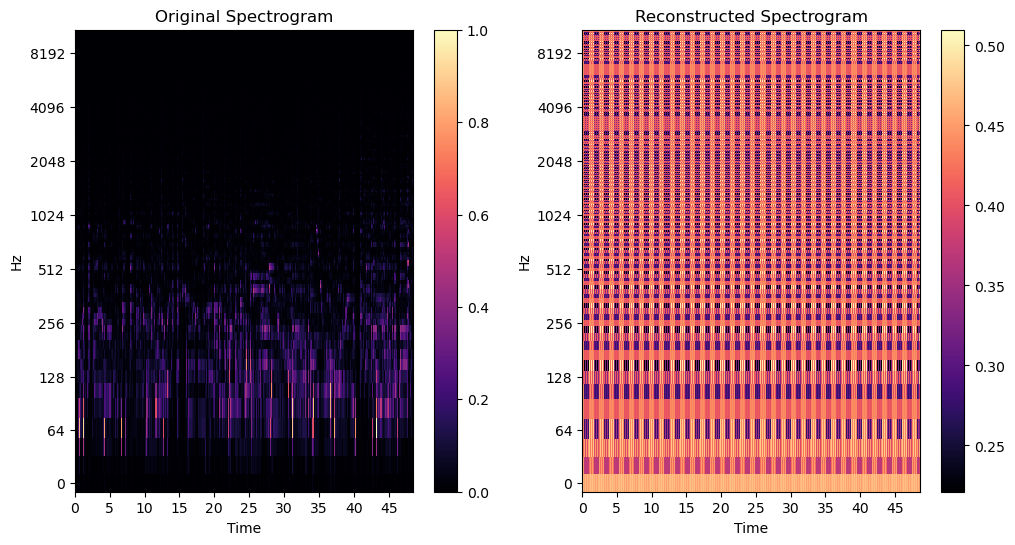

Reconstructed audio saved to reconstructed_output.wav


In [12]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.optim as optim
import soundfile as sf
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

#Custom PyTorch dataset, load files from a specified directory, normalize into mag spectrogram
class AudioDataset(Dataset):
    def __init__(self, directory, sr=22050, n_fft=1024, hop_length=512, transform=None):
        self.file_list = glob.glob(os.path.join(directory, '*.wav'))
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.transform = transform
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        audio, sr = librosa.load(file_path, sr=self.sr)
        stft = librosa.stft(audio, n_fft=self.n_fft, hop_length=self.hop_length)
        magnitude = np.abs(stft)
        magnitude = magnitude/np.max(magnitude)
        spectrogram_tensor = torch.tensor(magnitude, dtype=torch.float32).unsqueeze(0)
        if self.transform:
            spectrogram_tensor = self.transform(spectrogram_tensor)
        return spectrogram_tensor, file_path

# This hack fixes the multiprocessing pickling error by ensuring that the AudioDataset
# class is available as an attribute of the __main__ module.
import __main__
__main__.AudioDataset = AudioDataset

# Custom collate function to pad variable-length spectrogram tensors
def custom_collate_fn(batch):
    # batch is a list of tuples: (spectrogram_tensor, file_path)
    tensors, paths = zip(*batch)
    # Each tensor has shape [1, 513, time]
    max_time = max(t.shape[2] for t in tensors)
    padded_tensors = []
    for t in tensors:
        time_dim = t.shape[2]
        if time_dim < max_time:
            # Pad along the time dimension (last dimension); pad format: (pad_left, pad_right)
            import torch.nn.functional as F
            t = F.pad(t, (0, max_time - time_dim), mode='constant', value=0)
        padded_tensors.append(t)
    batch_tensor = torch.stack(padded_tensors, dim=0)
    return batch_tensor, list(paths)

#Simple NN Model
class AudioAutoEncoder(nn.Module):
    def __init__(self):
        super(AudioAutoEncoder, self).__init__()
        
        #Two convolutional layers reduce spatial dimensions
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=1, stride=2, padding=1), #Output (batch, 16, H/2, W/2)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=1, stride=2, padding=1), #Output (batch, 32, H/4, W/4)
            nn.ReLU()
        )

        #Two transposed Convolution restore OG dimensions
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() #Quick check on outputs between 0 and 1
        )
    def forward(self, x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return decoded

#Skeleton for training loop
def train_model(model, data, epochs=10, lr=1e-3, checkpoint_dir = 'checkpoints'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss() #Mean Squared Error loss for reconstruction
    writer = SummaryWriter(log_dir='runs/audio_autoencoder')

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in range(epochs):
        epoch_loss = 0.0
        model.train()
        for i, (batch, file_path) in enumerate(data):
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            if output.shape != batch.shape:
                target_h, target_w = batch.shape[2], batch.shape[3] #Cropping output if there's a mismatch
                output = output[:, :, :target_h, :target_w]
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            writer.add_scalar('Batch Loss', loss.item(), epoch * len(data)+i)
        avg_loss = epoch_loss / len(data)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(data):.6f}")
        writer.add_scalar('Epoch Loss', avg_loss, epoch)
        checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), checkpoint_path)
    writer.close()
    return model

#Reconstruct and save audio outputs
def evaluate_model(model, dataloader, output_dir='outputs', n_iter=32, hop_length=512, win_length=1024):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    with torch.no_grad():
        for i, (batch, file_paths) in enumerate(dataloader):
            batch = batch.to(device)
            reconstructed = model(batch)
            # Crop if necessary
            if reconstructed.shape != batch.shape:
                target_h, target_w = batch.shape[2], batch.shape[3]
                reconstructed = reconstructed[:, :, :target_h, :target_w]
            # Convert to NumPy array and remove extra dimensions
            reconstructed_np = reconstructed.cpu().numpy()  # shape: (B, C, H, W)
            B = reconstructed_np.shape[0]
            for j in range(B):
                rec_sample = np.squeeze(reconstructed_np[j])  # shape: (H, W)
                # Use Griffin–Lim algorithm to convert magnitude spectrogram to audio
                reconstructed_audio = librosa.griffinlim(rec_sample, n_iter=n_iter, hop_length=hop_length, win_length=win_length)
                base_filename = os.path.basename(file_paths[j])
                output_path = os.path.join(output_dir, 'reconstructed_' + base_filename)
                sf.write(output_path, reconstructed_audio, 22050)
                print(f"Reconstructed audio saved to {output_path}")

#Main Routine to load data, train, and inference
if __name__=="__main__":
     # Directory where your raw multitrack (or single track) audio files are stored
    audio_dir = 'data'  # <-- Ensure you have a 'data' directory with .wav files
    
    # Create dataset and DataLoader for efficient streaming
    dataset = AudioDataset(audio_dir)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=custom_collate_fn)
    
    # Initialize the autoencoder model
    model = AudioAutoEncoder()
    
    # Train the model on the dataset (this will load files on the fly)
    trained_model = train_model(model, dataloader, epochs=10, lr=1e-3)
    
    # Evaluate the trained model and reconstruct audio for all samples in the dataset
    evaluate_model(trained_model, dataloader)
    
    # Optional: Visualize a sample reconstruction for comparison
    sample_tensor, sample_path = dataset[0]
    model.eval()
    with torch.no_grad():
        sample_reconstructed = model(sample_tensor.unsqueeze(0))
    sample_reconstructed_np = sample_reconstructed.squeeze().cpu().numpy()
    
    # Load the original spectrogram for comparison
    _, original_spectrogram, sr = load_audio_compute_spectrogram(sample_path)
    #Showing the before and after spectrograms
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    librosa.display.specshow(original_spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='log')
    plt.title('Original Spectrogram')
    plt.colorbar()

    plt.subplot(1,2,2)
    librosa.display.specshow(sample_reconstructed_np, sr=sr, hop_length=512, x_axis='time', y_axis='log')
    plt.title('Reconstructed Spectrogram')
    plt.colorbar()
    plt.show()

    #Griffin Lim method reconstructs audio from spectrogram 
    reconstructed_audio = librosa.griffinlim(sample_reconstructed_np, n_iter=32, hop_length=512, win_length=1024)

    output_path = 'reconstructed_output.wav'
    sf.write(output_path, reconstructed_audio, sr)
    print(f"Reconstructed audio saved to {output_path}")


Next Steps:

Expand the Data Pipeline: Replace the dummy dataset with a proper DataLoader that reads and preprocesses your collection of raw multitracks.

Model Improvements: Experiment with deeper architectures or incorporate additional techniques (e.g., GANs or perceptual loss functions) as you refine your approach.

Integration with Logic Pro: Once you have reliable outputs, you can export high-quality WAV files to import into Logic Pro for further manual evaluation and mixing.

Documentation & Evaluation: Record your code modifications, training experiments, and evaluation metrics as you move toward your thesis paper and eventual IEEE submission.